# <p style ="text-align: center">YouTube's People & Blogs Category</p>

This notebook presents an Exploratory Data Analysis (EDA) of the "People & Blogs" category on YouTube. The goal of this analysis is to gain insights into the trends, patterns, and dynamics within this category over a specified period. We look to understand how getting into this category has historically affected channel growth and popularity. We also look to understand how the category has changed over time and how it compares to other categories.

### About the People & Blogs category

The "People & Blogs" category on YouTube comprises diverse content created by individuals or groups sharing personal experiences, opinions, lifestyle content, vlogs, and commentary. This category serves as a platform for content creators to engage with audiences by showcasing their daily lives, hobbies, thoughts, and perspectives.

Let's dive into the analysis !

# Imports

In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow.ipc as ipc
import pyarrow.feather as feather

from utils.loading import *

In [2]:
NOTEBOOK_PATH = os.getcwd()
DATA_PATH = os.path.join(NOTEBOOK_PATH, "data_youniverse")
CATEGORY = "People & Blogs"

# Data loading

In [3]:
df_channels_en = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
df_timeseries_en = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
df_feather = feather.read_feather(os.path.join(DATA_PATH, 'yt_metadata_helper.feather'))

### Plot Category distribution

Let's start our analysis by looking at the distribution of channels across categories. This will give us a sense of how popular the "People & Blogs" category is relative to other categories.

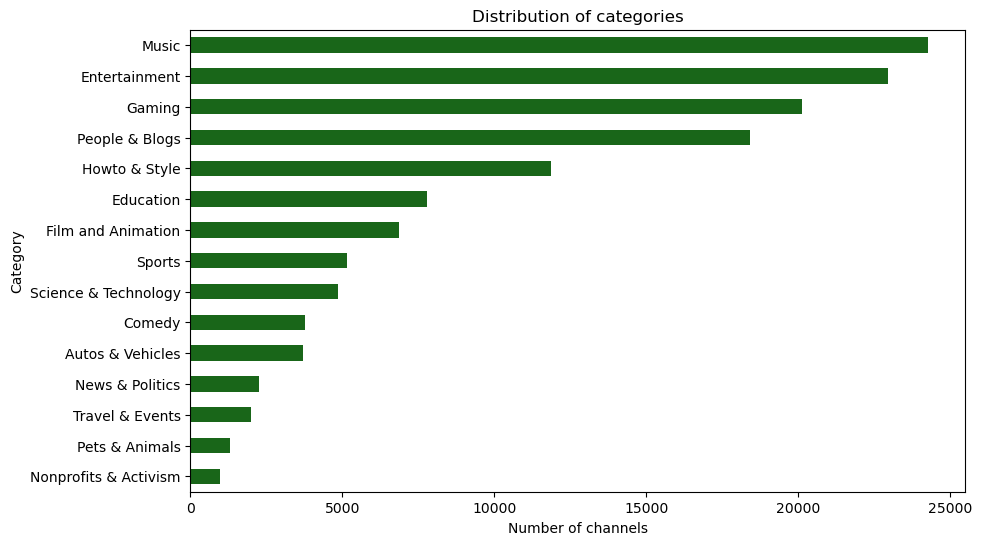

In [4]:
category_value_counts = df_channels_en["category_cc"].value_counts()

# Plot distribution of categories, emphasis on the People & Blogs category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_value_counts.values, y=category_value_counts.index, orient="h", color="g", saturation=0.6, width=0.5)
plt.title("Distribution of categories")
plt.xlabel("Number of channels")
plt.ylabel("Category")
plt.show();

As we can see, the "People & Blogs" category is the 4th most popular category on YouTube. It is only behind the "Entertainment", "Music", and "Gaming" categories. It will therefore be interesting to visit the dynamics within this category and understand how it has changed over time.

### Read People & Blogs channels' data

Let's extract the data for the "People & Blogs" category and look at the first few rows.

In [5]:
CATEGORY_FILE_NAME = ''.join(CATEGORY.split(" ")).lower()
CATEGORY_FILE_PATH = os.path.join(DATA_PATH, f"df_channels_{CATEGORY_FILE_NAME}.tsv.gz")

In [ ]:
# ONLY RUN THE FIRST TIME, LOAD AFTER

yt_metadata_filtered = load_and_filter_jsonl_gz_file_by_chunks(os.path.join(DATA_PATH, "yt_metadata_en.jsonl.gz"), CATEGORY)
yt_metadata_filtered.drop(columns=["categories"], inplace=True)
yt_metadata_filtered.to_csv(CATEGORY_FILE_PATH, index=False, compression="gzip")

In [6]:
df_yt_metadata_filtered = pd.read_csv(CATEGORY_FILE_PATH, compression="infer")
df_yt_metadata_filtered['upload_date'] = pd.to_datetime(df_yt_metadata_filtered['upload_date'])
df_yt_metadata_filtered.head()

,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:35.725333,0.0,LZPh8ky-RP8,175,8.0,"thomas train,thomas toby,thomas salty,thomas p...",2015-11-07,1307.0
1,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.405938,613.0,BDnF-EgqAGw,398,49464.0,"vine,vines,vine compilation,chaotic good",2019-02-05,1142835.0
2,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.959894,588.0,wrTIXbQED80,375,32726.0,"vines,vine,vine compilation,neutral good,align...",2019-01-31,819654.0
3,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.467288,1177.0,uyWL0ZWibyU,335,86222.0,"vine,vines,vine compilation,neutral evil",2019-01-22,2159837.0
4,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.948318,673.0,yd7d51AgSso,319,30596.0,NaN,2019-01-15,736707.0


In [7]:
df_yt_metadata_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6910666 entries, 0 to 6910665
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   channel_id     object        
 1   crawl_date     object        
 2   dislike_count  float64       
 3   display_id     object        
 4   duration       int64         
 5   like_count     float64       
 6   tags           object        
 7   upload_date    datetime64[ns]
 8   view_count     float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 474.5+ MB


# Exploratory Data Analysis

Now that we have loaded the data, let's dive into the analysis. We will start by looking at the dynamics within the "People & Blogs" category across the years.

## Upload date analysis

We first take a look at the proportion of videos uploaded in each year that belong to the "People & Blogs" category. This will give us a sense of how the category's importance has changed over time.

### Plot the proportion of videos uploaded per year coming from People & Blogs category

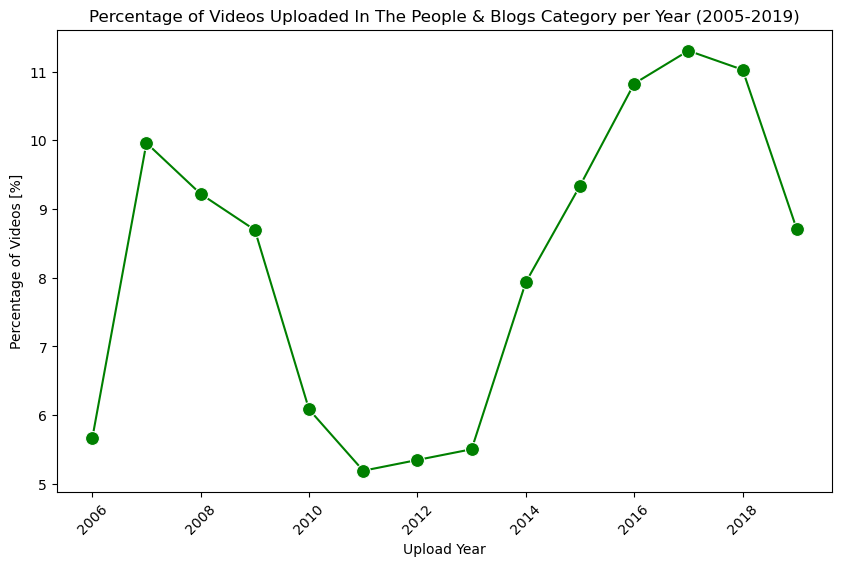

In [8]:
all_cc_yearly_video_count = df_feather["upload_date"].dt.year.value_counts().sort_index()
pb_yearly_video_count = df_feather[df_feather["categories"]==CATEGORY]["upload_date"].dt.year.value_counts().sort_index()

# calculate percentage of videos in People & Blogs category
pb_percentage = pb_yearly_video_count / all_cc_yearly_video_count * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=pb_percentage.index, y=pb_percentage.values, color="g", marker="o", markersize=10)
plt.xticks(rotation=45)
plt.ylabel("Percentage of Videos [%]")
plt.xlabel("Upload Year")
plt.title("Percentage of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

We can see that the "People & Blogs" category had a slower growth in the early years compared to other categories. It then grew rapidly between 2012 and 2017, the year where it peaked. It represented more than 11% of the videos uploaded that year. Since then, the category has been stagnating in 2018. It represents less than 9% of the videos uploaded in 2019, the last year with recorded data. However, we don't have complete data for 2019, as crawl time last until 2019-11-23.

These observations align with our intuition. The "People & Blogs" category is a relatively new category on YouTube. It was created in 2006, 1 year after the platform's launch. It has since grown rapidly and has become one of the most popular categories on YouTube. However, it has been declining in importance since 2017, with content creators fluctuating between genres.

The big drop in upload proportion from 2009 to 2013 is likely due to the rise of the "Gaming" category. This category was created much earlier but only started gaining popularity in 2013. It has since become the 3rd most popular category on YouTube.

### Category evolution over time

Having looked at the proportion of videos uploaded per year, let's now take a look at the number of videos uploaded within the category per year. This will give us a sense of how active the category has gotten over time.

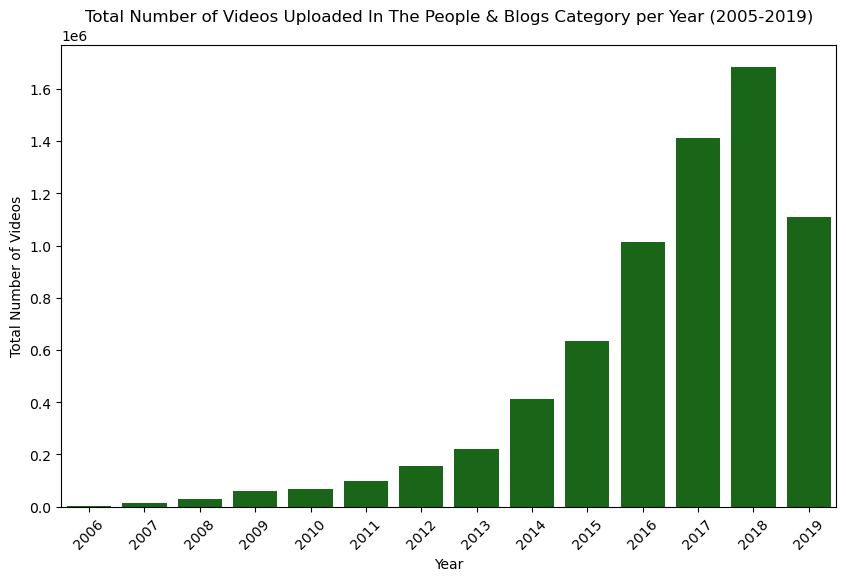

In [9]:
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=pb_yearly_video_count.index, y=pb_yearly_video_count.values, color="g", saturation=0.6)
plt.xticks(rotation=45)
plt.ylabel("Total Number of Videos")
plt.xlabel("Year")
plt.title("Total Number of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

The results look interesting, however we will look at the log scale values to get a better sense of the upload dynamics.

### Apply log scale to the y-axis

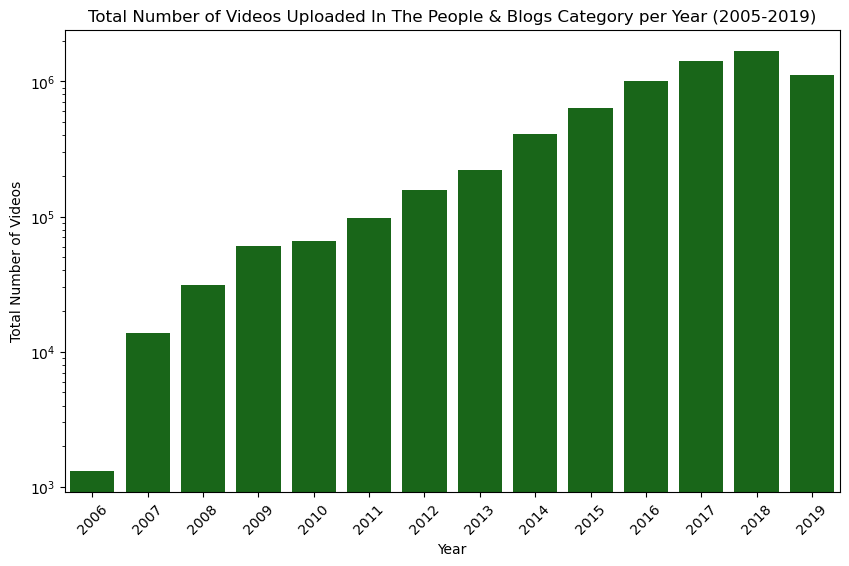

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pb_yearly_video_count.index, y=pb_yearly_video_count.values, color="g", saturation=0.6)
plt.yscale("log")
plt.xticks(rotation=45)
plt.ylabel("Total Number of Videos")
plt.xlabel("Year")
plt.title("Total Number of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

We can clearly see a rapid growth in the number of videos uploaded within the "People & Blogs" category between 2012 and 2017. This aligns with our previous observation that the category grew rapidly during this period. This growth appears to be linear in log scale, which means that the category was growing exponentially. The last recorded data in 2019 however appears to show a decline in the number of videos uploaded within the category. This is explained by the fact that we do not possess data for the last 2 months of 2019.

## Video duration distribution

We will now explore the distribution of video durations within the "People & Blogs" category. This will give us a sense of the type of content that is being created within the category.

In [11]:
df_yt_metadata_filtered.sample(5)

,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
4789648,UCFMNNg2J3QVKchxQeNyaeDA,2019-11-06 22:36:51.536838,2.0,dZ-yRH1frRs,881,9.0,"DIDI2018,29-01-2018,didi tonev,zagreb,croatia,...",2018-02-28,431.0
2072988,UCxXTyFekH99JnS3qaXIQW7A,2019-11-01 02:32:53.360862,0.0,RzeGJ3RgZtk,112,3.0,"texas-legislature,texas,crime,politics,news",2019-03-20,124.0
1075387,UCyFyBt-scA9yp5Nwu-mXB1Q,2019-11-08 19:39:20.108278,1.0,8J_JiZNEQGA,167,90.0,"Bobcat Excavator,Taking down tree,Mini Excavat...",2017-04-22,1948.0
3731074,UCNqbcf-5nORpyfzrqQNLSVw,2019-11-08 05:26:52.230772,NaN,aUOHLwQKc9o,123,NaN,"health,sports,training,fitness,nutrition,Mike ...",2016-07-18,26648.0
6271374,UC2zlRzqMd3I9xd3g4nOVx6Q,2019-10-30 16:51:31.617069,0.0,2b_iHyxond0,182,3.0,NaN,2017-07-02,88.0


In [12]:
df_feather['upload_year'] = df_feather['upload_date'].dt.year

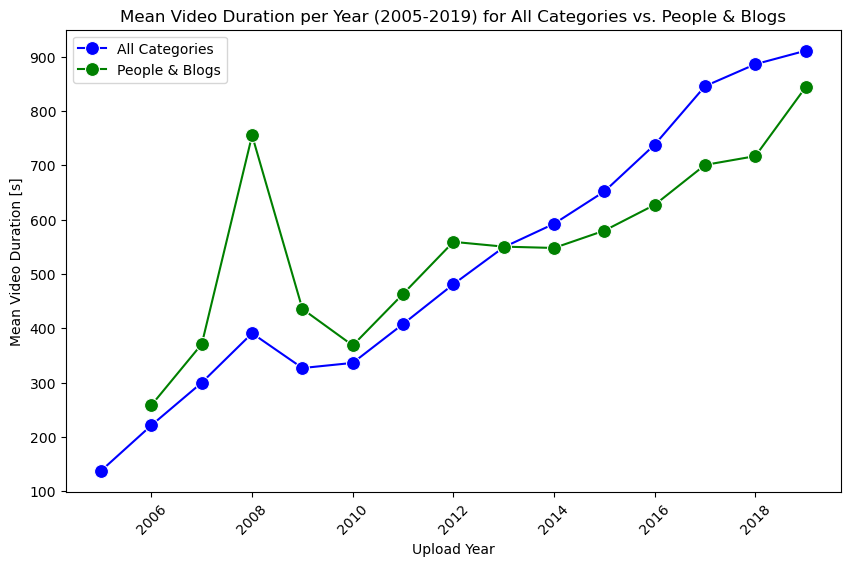

In [13]:
all_cc_mean_video_duration = df_feather.groupby("upload_year")["duration"].mean()
pb_mean_video_duration = df_feather[df_feather["categories"]==CATEGORY].groupby("upload_year")["duration"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=all_cc_mean_video_duration.index, y=all_cc_mean_video_duration.values, color="b", marker="o", markersize=10, label="All Categories")
sns.lineplot(x=pb_mean_video_duration.index, y=pb_mean_video_duration.values, color="g", marker="o", markersize=10, label="People & Blogs")
plt.xticks(rotation=45)
plt.ylabel("Mean Video Duration [s]")
plt.xlabel("Upload Year")
plt.title("Mean Video Duration per Year (2005-2019) for All Categories vs. People & Blogs")
plt.legend()
plt.show();

We observe that the general trend over the years is that videos on YouTube are getting longer. This is likely due to the fact that YouTube's algorithm favors longer videos. This is because longer videos tend to have higher watch times, which is a key metric for YouTube's algorithm. This is also likely due to the fact that content creators are experimenting with longer formats, as a part of them is professionalizing.

We also see that the "People & Blogs" category has a similar distribution to the overall distribution. This means that the category follow the general variations in terms of video duration. It has however recently fallen under the overall average for the last 5 years, which again could align with the fact that the category has been declining in popularity recently.

## Like to dislike ratio analysis

We will continue our analysis by looking at the like to dislike ratio within the "People & Blogs" category. This will give us a sense of how the category is perceived by viewers.

In [14]:
df_feather["like_rate"] = df_feather["like_count"] / (df_feather["like_count"] + df_feather["dislike_count"])

df_feather.sample(5)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,upload_year,like_rate
39146625,Gaming,UCNgSZzvPJL4goZuVgUFhFew,2.0,0RgW38aAkLc,601,7.0,2013-03-17,86.0,2013,0.777778
15407477,News & Politics,UCfezf9jVcGECLAJ8Y915ooA,0.0,LcZPQpSOMdg,238,2.0,2017-09-23,380.0,2017,1.000000
48146476,News & Politics,UCGyZswzm4G-wEfRQHgMSAuw,3.0,8aJ5Ov96Vd4,81,21.0,2019-06-11,1805.0,2019,0.875000
18807900,Autos & Vehicles,UCd59GjNE4ZwQ15dAElEmf5Q,0.0,rBBF2TRRrZ8,248,1.0,2016-07-26,242.0,2016,1.000000
33995098,Entertainment,UCRxrTzSuEFLI3YEBjEzI22A,0.0,rd9ePaoHbWc,2550,30.0,2017-12-08,1069.0,2017,1.000000


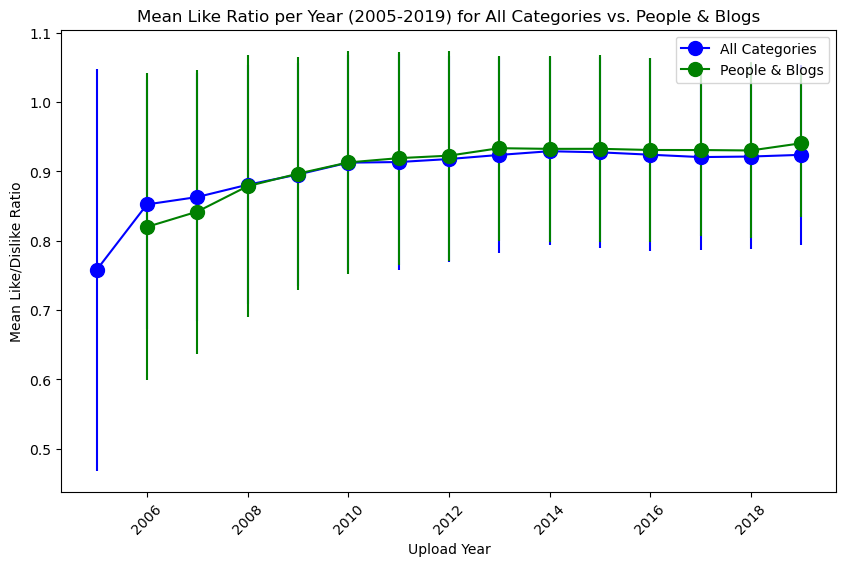

In [30]:
df_non_na_like_rate = df_feather[df_feather["like_rate"].notnull()]

all_cc_mean_like_rate = df_non_na_like_rate.groupby("upload_year")["like_rate"].agg(["mean", "std"])
pb_mean_like_rate = df_non_na_like_rate[df_non_na_like_rate["categories"]==CATEGORY].groupby("upload_year")["like_rate"].agg(["mean", "std"])

plt.figure(figsize=(10, 6))
plt.errorbar(x=all_cc_mean_like_rate.index, y=all_cc_mean_like_rate["mean"], yerr=all_cc_mean_like_rate["std"], color="b", marker="o", markersize=10, label="All Categories")
plt.errorbar(x=pb_mean_like_rate.index, y=pb_mean_like_rate["mean"], yerr=pb_mean_like_rate["std"], color="g", marker="o", markersize=10, label="People & Blogs")
plt.xticks(rotation=45)
plt.ylabel("Mean Like/Dislike Ratio")
plt.xlabel("Upload Year")
plt.title("Mean Like Ratio per Year (2005-2019) for All Categories vs. People & Blogs")
plt.legend()
plt.show();

In [22]:
all_cc_mean_like_rate['mean']

upload_year
2005    0.757874
2006    0.852425
2007    0.863086
2008    0.880807
2009    0.895547
2010    0.912690
2011    0.913558
2012    0.917888
2013    0.923801
2014    0.929168
2015    0.927578
2016    0.924137
2017    0.920713
2018    0.921493
2019    0.923948
Name: mean, dtype: float64

Observing the like to dislike ratio over time, we see that it has held a steady value of around 0.9 for the last 10 years. This means that the category has been consistently well received by viewers. This is likely due to the fact that the category is very diverse and that it is easy for viewers to find content that they enjoy. Most users watching videos within the category are likely to be interested in the particular YouTuber's personnality and content, which explains the high like to dislike ratio.

## Tag Analysis

We now have a general idea of the growth and popularity trends within the category. Another aspect of the data we can explore lies in the video tags. To do so, we will perform a Principal Component Analysis (PCA) on them, which will allow us to reduce the dimensionality of the data and visualize the tags in a 2D space. We will then perform a KMeans clustering on the tags to identify groups of similar tags. The idea is to identify the main topics that are being discussed within the category, which will allow us to define the most popular subcategories within the genre.

In [77]:
from collections import Counter
import gensim.downloader as api
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# ONLY RUN THE FIRST TIME, LOAD AFTER

tags = df_yt_metadata_filtered['tags'].str.split(',', expand=True).stack()
tags = tags.str.strip().str.lower()
tags = pd.Series(tags[tags != ''].unique())
# save tags to file
tags.to_csv(os.path.join(DATA_PATH, "tags.tsv.gz"), index=False, compression="gzip")

In [62]:
tags = pd.read_csv(os.path.join(DATA_PATH, "tags.tsv.gz"), compression="infer", header=None, names=["tag"])['tag'].dropna()

### Frequency Analysis


In [60]:
all_tags = [tag for sublist in tags for tag in sublist]
tag_counts = Counter(all_tags)
most_common_tags = tag_counts.most_common(20)  # Get the 20 most common tags

In [ ]:
categories, counts = zip(*most_common_tags)

# Plotting
plt.figure(figsize=(10,8))
plt.barh(categories, counts, color='green')
plt.xlabel('Counts')
plt.title('Bar Plot of Categories')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()

"Vlog" is the most popular subcategory, with the highest count, indicating that it is the most frequently occurring or perhaps the most tagged within the "Blogs & People" category. The counts generally decrease for other subcategories like "funny", "family", "love", and so on, showing a declining order of prevalence. This suggests that while vlogging is the dominant type of content, there is still a significant diversity of topics that creators focus on within this category.

### Dimensionality Reduction w. PCA & Term Frequency Inverse Document Frequency (TFID vectorizer)

In [99]:
num_tags = 10_000

In [100]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(tags[:num_tags])

In [101]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=10) # n_init is set to avoid warning message
clusters = kmeans.fit_predict(tfidf_matrix)


In [102]:
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(np.asarray(tfidf_matrix.todense()))

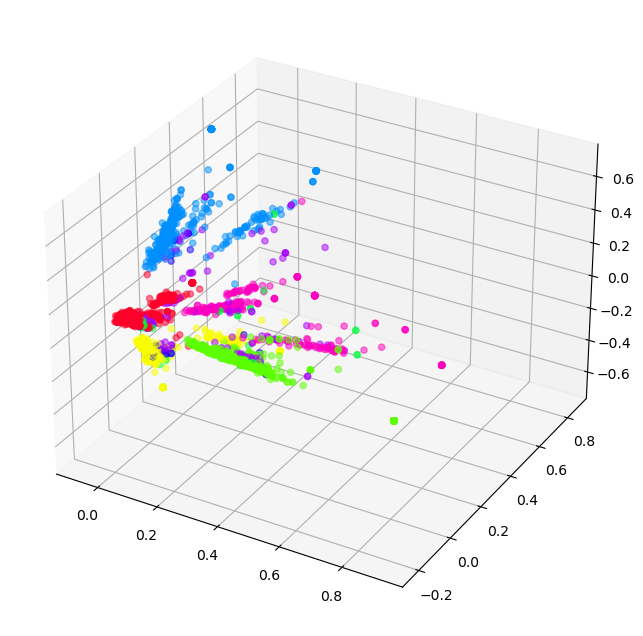

In [103]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], c=clusters, cmap='gist_rainbow', alpha=0.5)
plt.show()

Let's see what each cluster contains

In [104]:
df_clusters = pd.DataFrame({'cluster': clusters, 'tag': tags[:num_tags]})

df_clusters['cluster'].value_counts()

cluster
0    7966
3     563
6     419
2     345
9     315
8     169
4     108
7      61
5      43
1      11
Name: count, dtype: int64

In [105]:
df_clusters[df_clusters['cluster'] == 0]['tag']

0                                       0
1                            thomas train
2                             thomas toby
3                            thomas salty
4                           thomas pirate
                      ...                
9995           connection with other side
9996                   going to the light
9997    first holiday without a loved one
9998                  help for depression
9999                      depression help
Name: tag, Length: 7966, dtype: object

Upon plotting the tags, and verifying the tag contents, we notice that the cluster assigments seem to be random and misblanced. This is because TF-IDF struggles with clustering individual tags because it's designed for contexts with larger documents, where term frequency contrasts with the document corpus. In the case of individual tags, each tag is effectively its own document without context, making TF-IDF less effective. Let's try another approach.

### Dimentionality reduction with GloVe embeddings

Here, we will use the GloVe embeddings to reduce the dimentionality of the tags. We will use the 100-dimensional GloVe embeddings. The embeddings are obtained from a pre-trained model on Wikipedia 2014 + Gigaword 5. The model can be downloaded using the gensim library.

#### Load GloVe model and filter out tags that are not in the model

In [106]:
model = api.load("glove-wiki-gigaword-100") 

filtered_tags = [tag for tag in tags if tag in model]
tag_embeddings = np.array([model[tag] for tag in filtered_tags])

In [107]:
kmeans_glove = KMeans(n_clusters=n_clusters, n_init=10)
clusters_glove = kmeans_glove.fit_predict(np.array(tag_embeddings))

In [108]:
tsne = TSNE(n_components=3, random_state=0, perplexity=50)
tag_vectors_3d = tsne.fit_transform(tag_embeddings)

KeyboardInterrupt: 